Выполнил: Колесников Дмитрий
# Условие проекта:

Вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

### Проверьте:

1) Был ли эксперимент успешен в целом.

2) Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.


*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

### Информация о данных:
**Всего есть три группы:** тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

**users_*.csv** – информация о пользователях:

uid – идентификатор пользователя <br />
age – возраст <br />
attraction_coeff – коэффициент привлекательности (в диапазоне от 0 до 1000) - соотношение числа лайков к показам, уможенное на 1000 <br />
coins – число монеток (внутренняя валюта) <br />
country – страна  <br />
visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)<br />
gender – пол<br />
age_filter_start  – фильтр поиска, мин. значение <br />
age_filter_end  – фильтр поиска, макс. значение <br />
views_count – число полученных оценок <br />
was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги) <br />
is_premium –  является ли премиум <br />
total_revenue – нормированная выручка <br />
 
 
**transactions_*.csv** – информация о платежах пользователей:

uid – идентификатор пользователя<br />
country – страна<br />
joined_at – дата и время регистрации<br />
paid_at – дата и время покупки <br />
revenue – нормированная выручка <br />
payment_id – идентификатор платежа <br />
from_page – откуда пользователь перешел на страницу оплаты <br />
product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) <br />

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import f_oneway, norm, mannwhitneyu, chi2_contingency
from tqdm.auto import tqdm
from scipy import stats
from statsmodels.graphics.mosaicplot import mosaic

In [206]:
users_test = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/L8HxRYDn2l4h9A', sep=';')
users_control_1  = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/TxOD_JxnkMd4mA', sep=';')
users_control_2 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/YT6OWRK2cTWfLg', sep=';')
transactions_test = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3viYBnm7cyihkQ', sep=';')
transactions_control_1 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84jzzJeQ4tqVyg', sep=';')
transactions_control_2 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/_pOo7mrDCZZMyA', sep=';')

In [207]:
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [208]:
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [209]:
print(f'число сторок в датасетах transactions:  ',transactions_test.shape[0], ',',
      transactions_control_1.shape[0], ',', transactions_control_2.shape[0])

число сторок в датасетах transactions:   273 , 1007 , 328


In [210]:
print(f'число строк в датасетах users:  ',users_test.shape[0], ',',
      users_control_1.shape[0], ',', users_control_2.shape[0])

число строк в датасетах users:   4308 , 4340 , 4264


Объединим данные users в одну совместную таблицу в которой coздадим отдельную колонку для указания из какой первоначальной таблицы взяты данные. <br />
Обозначения примем следующие: <br />
А1 - users_control_1 <br />
А2 - users_control_2 <br />
В - users_test <br />

In [211]:
users_test['group'] = 'B'
users_control_1['group'] = 'A1'
users_control_2['group'] = 'A2'
users = pd.concat([users_test, users_control_1, users_control_2])

In [212]:
if users[users.index.duplicated()].shape[0] != 0:
    users = users.reset_index()
    print('Сброшены индексы из-за дублирования')
    users.drop('index', axis=1, inplace=True)

Сброшены индексы из-за дублирования


In [213]:
users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,B
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,B
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,B
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,B
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,B


In [214]:
users.group.value_counts()  # Проверка того, что все данные присоединены

A1    4340
B     4308
A2    4264
Name: group, dtype: int64

Объединим данные transactions в одну совместную таблицу в которой coздадим отдельную колонку для указания из какой первоначальной таблицы взяты данные. <br />
Обозначения примем следующие: <br />
А1 - transactions_control_1 <br />
А2 - transactions_control_2 <br />
В - transactions_test <br />

In [215]:
transactions_test['group'] = 'B'
transactions_control_1['group'] = 'A1'
transactions_control_2['group'] = 'A2'
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2])

In [216]:
if transactions[transactions.index.duplicated()].shape[0] != 0:
    transactions = transactions.reset_index()
    print('Сброшены индексы из-за дублирования')
    transactions.drop('index', axis=1, inplace=True)

Сброшены индексы из-за дублирования


In [217]:
transactions.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,B
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,B
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,B
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,B
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,B


In [218]:
transactions.group.value_counts()  # Проверка того, что все данные присоединены

A1    1007
A2     328
B      273
Name: group, dtype: int64

### Предобработка данных users:

In [219]:
users.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
group                object
dtype: object

Узнаем, сколько осталось пропущенных значений в таблице:

In [220]:
users.isna().sum()

uid                     0
age                     0
attraction_coeff        0
coins               12742
country                 0
visit_days           4018
gender                  0
age_filter_start        0
age_filter_end          0
views_count             0
was_premium         11657
is_premium          12372
total_revenue           0
group                   0
dtype: int64

In [221]:
users.gender = users.gender.apply(lambda x: 'male' if x == 1 else 'female')

In [222]:
# Переведем колонки класса объект в строку:
users = users.astype({'country': 'str', 'visit_days': 'str', 'group': 'str'})

In [223]:
users.query('was_premium != 1 and is_premium == 1.0').shape[0]

0

Для анализа данных полезным будет создать колонку с информацией о том, был ли хоть раз у пользователя премиум. Обратим внимание на то, что если пользователь является премиумом на данный момент, то это означает, что у него в колонке was_premium будет единица. Для дальнейшего анализа для нас не является важным, имеется ли премиум сейчас, так что данную колонку можно удалить, а was_premium переименовать в premium и заполнить пропуски нулями

In [224]:
users = users.drop(columns=['is_premium'])
users = users.rename(columns={'was_premium': 'premium'})
users['premium'] = users['premium'].fillna(0)

Если у пользователя нет монеток, то это значит, что у него их 0 штук, поэтому заменим nan на 0

In [225]:
users['coins'] = users['coins'].fillna(0)

In [226]:
users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,premium,total_revenue,group
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",male,24,30,89,0.0,0,B
1,892044516,27,0,0.0,Germany,nan,male,24,30,0,0.0,0,B
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",male,42,48,68,0.0,0,B
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",male,29,35,0,0.0,0,B
4,891406035,27,1000,0.0,France,nan,male,24,30,1,1.0,0,B


На платформе присутствуют 3 типа пользователей: <br />
1) Те, кто приобретал платную подписку <br />
2) Те, кто только лишь использовал пробную версию, не купив платную<br />
3) Те, кто не платил деньги и не пробовал пробную версию

Создадим колонку с информацией о типе пользователя. 1 категория - payer, 2 категория - probe, 3 категория - free

In [227]:
def user_type(premium, revenue):
    if premium == 1 and revenue > 0:
        return 'payer'
    elif premium == 1 and revenue == 0:
        return 'probe'
    else:
        return 'free'

In [228]:
users['user_type'] = users.apply(lambda x: user_type(x.premium, x.total_revenue), axis = 1)

In [229]:
df = users.user_type.value_counts().to_frame().reset_index()\
    .rename(columns={'index': 'type'})
df

,type,user_type
0,free,11657
1,probe,761
2,payer,494


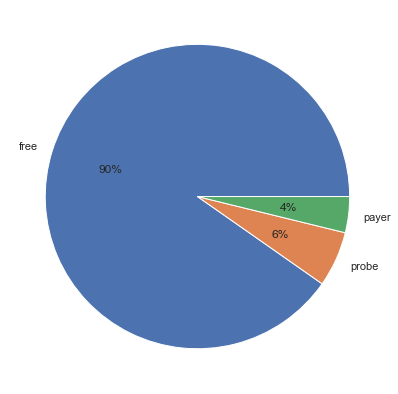

In [231]:
plt.pie(df.user_type, labels=df.type, autopct='%.0f%%')
sns.set(rc={'figure.figsize': (7, 7)})
plt.show()

Большинство людей используют именно бесплатную версию приложения и даже не пробуют премиум версию. Как мы видим, число людей с пробной версией превышает число тех, кто приобрел платную. Для оценки изменений до и после проведения A/B теста можно будет использовать метрику конверсии пользователей из probe в payer. Но про постановку А/B тестирования будем говорить чуть позже. Пока лишь постановка идей

Получим колонку с числом дней, которые провел пользователь на платформе. Для этого преобразуем колонку visit_days. Но сначала обратим внимание на nan и их природу появления 

In [232]:
users.query('visit_days == "nan" and user_type == "payer"').shape[0]

50

Выглядит очень подозрительным тот факт, что имеются пользователи с купленной подпиской на премиум и при этом с 0 числом посещенных дней приложения. Это говорит о том, что nan в столбце visit_days не означает, что пользователи не посетили платформу. Скорее всего есть ошибка, по которой часть данных была потеряна и вместо списка дней посещения появились пропуски в таблице

In [233]:
users.query('visit_days == "nan"').shape[0]

4018

Так как значений с nan слишком много, поэтому нецелесообразным будет их удаление. <br />
Я сделаю следующим образом: сначала найду медианные значения числа дней для каждого из типов пользователей (user_type). <br />
Укажу для пользователей с nan значения числа дней посещения равными медианным значениям для конкретной категории. <br />
(ex: То есть если пользователь с платной версией и число дней не определено, то поставим ему медианное значение числа дней для категории payers у которых данные есть)

Создадим временную колонку и инфой о числе дней без учета nan:

In [234]:
users['temperary_days'] = users['visit_days'].apply(lambda x: len(x.split(',')))

In [235]:
print('Медианное значения числа дней посещения приложения для пользователей без премиума:',
    users.query('visit_days != "nan" and user_type == "free"')\
    .temperary_days.median())

Медианное значения числа дней посещения приложения для пользователей без премиума: 4.0


In [236]:
print('Медианное значения числа дней посещения приложения для пользователей с пробным премиумом:',
    users.query('visit_days != "nan" and user_type == "probe"')\
    .temperary_days.median())

Медианное значения числа дней посещения приложения для пользователей с пробным премиумом: 5.0


In [237]:
print('Медианное значения числа дней посещения приложения для пользователей с платным премиумом:',
    users.query('visit_days != "nan" and user_type == "payer"')\
    .temperary_days.median())

Медианное значения числа дней посещения приложения для пользователей с платным премиумом: 9.0


Как мы видим, когда человек покупает премиум, то он чаще посещает приложение. Пробная подписка тоже, хоть и немного, но стимулирует пользователей чаще заходить на платформу

In [238]:
def func_nan (visit_days, user_type, temperary_days):
    if visit_days == 'nan' and user_type == 'free':
        return users.query('visit_days != "nan" and user_type == "free"')\
                .temperary_days.median()
    elif visit_days == 'nan' and user_type == 'probe':
        return users.query('visit_days != "nan" and user_type == "probe"')\
                .temperary_days.median()
    elif visit_days == 'nan' and user_type == 'payer':
        return users.query('visit_days != "nan" and user_type == "payer"')\
                .temperary_days.median()
    else:
        return temperary_days

In [239]:
users['days'] = users.apply(lambda x: func_nan(x.visit_days, x.user_type, x.temperary_days), axis=1)

Удалим лишние колонки и дубликаты юзеров:

In [240]:
users.groupby('uid').agg({'group': 'count'}).max()  

group    1
dtype: int64

Значит, что нет повторов пользователей в выборках, поэтому не требуется проводить удаление дубликатов

In [241]:
users.drop(['visit_days', 'temperary_days'], axis=1, inplace=True)

In [242]:
users.head()

,uid,age,attraction_coeff,coins,country,gender,age_filter_start,age_filter_end,views_count,premium,total_revenue,group,user_type,days
0,892309896,27,685,0.0,United States of America,male,24,30,89,0.0,0,B,free,14.0
1,892044516,27,0,0.0,Germany,male,24,30,0,0.0,0,B,free,4.0
2,892185708,45,44,0.0,Israel,male,42,48,68,0.0,0,B,free,20.0
3,892130292,32,0,0.0,United States of America,male,29,35,0,0.0,0,B,free,12.0
4,891406035,27,1000,0.0,France,male,24,30,1,1.0,0,B,probe,5.0


По условию сказано, что изменения цены подписки произошли лишь в некоторых странах. Сделаем так, чтобы в датасете остались лишь те страны, которые присутствуют в тестовой выборке, ведь в них и произошли изменения

In [243]:
df = users.groupby(['country', 'group'], as_index=False).agg({'uid': 'count'})\
    .rename(columns = {'uid': 'amount'})
pivot = df.pivot_table(index = 'country', columns='group', values='amount',
    fill_value=0).reset_index()
pivot.head(7)

group,country,A1,A2,B
0,Algeria,2,0,2
1,Argentina,389,397,396
2,Armenia,1,0,0
3,Australia,50,51,62
4,Austria,0,2,0
5,Azerbaijan,0,0,1
6,Belarus,0,1,0


Будем использовать только те страны, которые содержат хотя бы по одному представителю в каждой из групп (A1, A2, B) для реализации более качественной системы сплитования подвыборок 

In [244]:
country_ok = list(pivot.query('A1 != 0 and A2 != 0 and B != 0').country)

In [245]:
users = users.query('country in @country_ok')
users.group.value_counts()

A1    4319
B     4271
A2    4238
Name: group, dtype: int64

После окончания предобработки данных число данных практически не уменьшилось. Мы смогли сформировать датасет, с которым в дальнейшем будем проводить ААВ тест и изучать общие закономерности по взаимодействию юзеров на дейтинговой платформе

### Анализ предобработанных данных users:

In [246]:
users.nunique()

uid                 12828
age                    68
attraction_coeff      843
coins                  51
country                25
gender                  2
age_filter_start       67
age_filter_end         81
views_count           559
premium                 2
total_revenue         291
group                   3
user_type               3
days                   31
dtype: int64

In [247]:
users.describe(include='object')

,country,gender,group,user_type
count,12828,12828,12828,12828
unique,25,2,3,3
top,United States of America,male,A1,free
freq,4407,12252,4319,11579


In [248]:
users.describe(include=['float', 'int'])

,uid,age,attraction_coeff,coins,age_filter_start,age_filter_end,views_count,premium,total_revenue,days
count,1.282800e+04,12828.000000,12828.000000,12828.000000,12828.000000,12828.000000,12828.000000,12828.000000,12828.000000,12828.000000
mean,8.917563e+08,32.010602,314.804880,9.129326,26.834347,38.560571,46.093234,0.097365,527.555971,5.815560
std,1.615224e+06,10.226745,323.369774,886.304934,9.456984,15.485199,283.676377,0.296466,5539.912796,5.528776
min,8.910509e+08,16.000000,0.000000,0.000000,13.000000,19.000000,0.000000,0.000000,0.000000,1.000000
25%,8.913558e+08,25.000000,0.000000,0.000000,19.000000,28.000000,1.000000,0.000000,0.000000,3.000000
50%,8.917248e+08,30.000000,250.000000,0.000000,25.000000,35.000000,6.000000,0.000000,0.000000,4.000000
75%,8.920853e+08,38.000000,527.000000,0.000000,32.000000,45.000000,21.000000,0.000000,0.000000,7.000000
max,1.053059e+09,99.000000,1000.000000,99958.000000,96.000000,102.000000,16157.000000,1.000000,486330.000000,31.000000


In [249]:
users.head()

,uid,age,attraction_coeff,coins,country,gender,age_filter_start,age_filter_end,views_count,premium,total_revenue,group,user_type,days
0,892309896,27,685,0.0,United States of America,male,24,30,89,0.0,0,B,free,14.0
1,892044516,27,0,0.0,Germany,male,24,30,0,0.0,0,B,free,4.0
2,892185708,45,44,0.0,Israel,male,42,48,68,0.0,0,B,free,20.0
3,892130292,32,0,0.0,United States of America,male,29,35,0,0.0,0,B,free,12.0
4,891406035,27,1000,0.0,France,male,24,30,1,1.0,0,B,probe,5.0


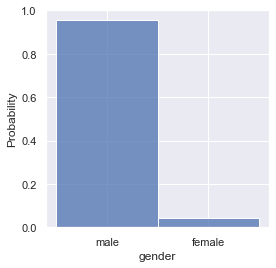

In [251]:
sns.histplot(data=users, x='gender', stat='probability')
sns.set(rc={'figure.figsize': (4, 4)})
plt.show()

Процентное соотношение числа мужчин на сайте знакомств значительно выше числа женщин

Изучение возрастных характеристик:

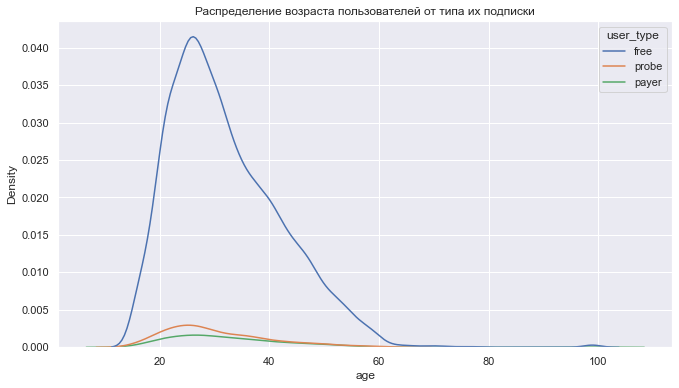

In [253]:
sns.kdeplot(data=users, x="age", hue='user_type')\
    .set_title("Распределение возраста пользователей от типа их подписки")
sns.set(rc={'figure.figsize': (11, 6)})
plt.show()

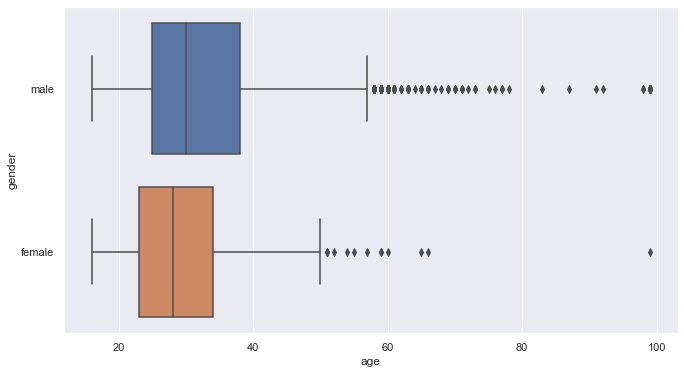

In [255]:
sns.boxplot(data=users, x="age", y="gender")
sns.set(rc={'figure.figsize': (11, 6)})
plt.show()

Как можно заметить возраст мужчин в среднем выше, чем у женщин на платформе. Имеются в данных выбросы. Предполагаю, что это нечестное указание возраста, ведь сайт вряд ли проверяет по паспорту

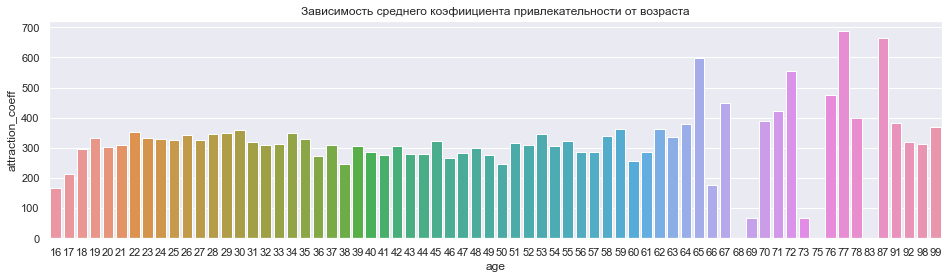

In [257]:
df = users.groupby(['age'], as_index=False).agg({'attraction_coeff': 'mean'})
sns.barplot(data=df, x="age", y='attraction_coeff')\
    .set_title("Зависимость среднего коэфиициента привлекательности от возраста")
sns.set(rc={'figure.figsize': (16, 4)})
plt.show()

Можно сделать вывод, что нет зависимости параметра привлекательности от возраста пользователей. Соотношение среднего числа лайков на число просмотров не изменяется 

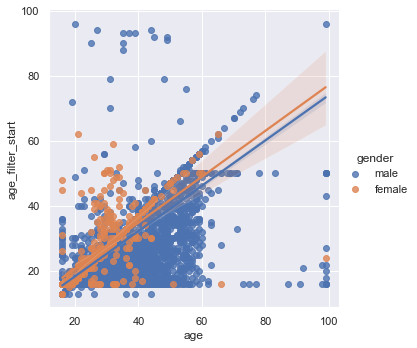

In [259]:
sns.lmplot(x="age", y="age_filter_start", hue="gender", data=users)
sns.set(rc={'figure.figsize': (10, 5)})

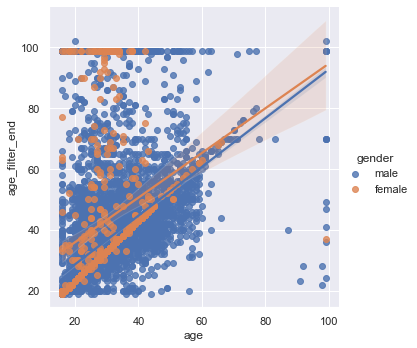

In [260]:
sns.lmplot(x="age", y="age_filter_end", hue="gender", data=users)
sns.set(rc={'figure.figsize': (10, 5)})

Изучим корреляцию количественных данных:

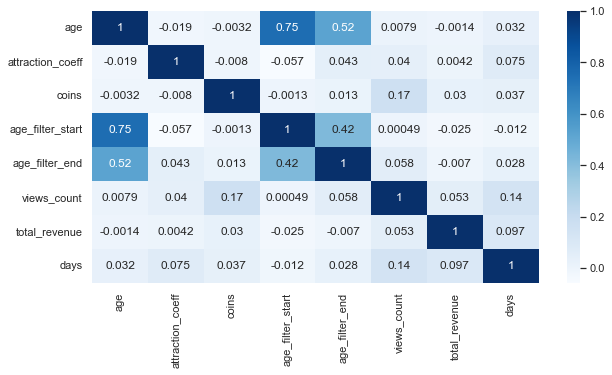

In [261]:
sns.heatmap(users[['age', 'attraction_coeff', 'coins', 'age_filter_start',
    'age_filter_end', 'views_count', 'total_revenue', 'days']]\
    .corr(), annot=True, cmap='Blues');

Значимая корреляция имеется только с данными возрастных фильтров и возраста самого пользователя. <br />
Возраст нижней границы поиска прямо пропорционален возрасту юзера. При этом зависимость верхней границы менее коррелирует со значением возраста пользователя. Предположение, объясняющее данный факт: часть пользователей ищет партнера постарше или просто не указывает верхнюю границу (она ставится автоматом 100 лет)

Изучим параметр привлекательности:

Проведя тест на корреляцию, стало ясно, что нет никаких зависимостей этого параметра конверсии просмотра в лайк от количественных величин. Так что изучим взаимосвязь с качественными:

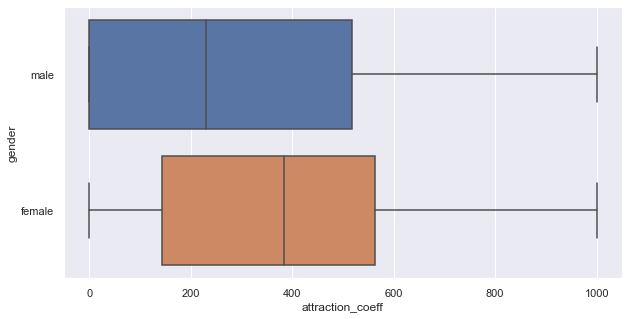

In [262]:
sns.boxplot(data=users, x="attraction_coeff", y="gender");

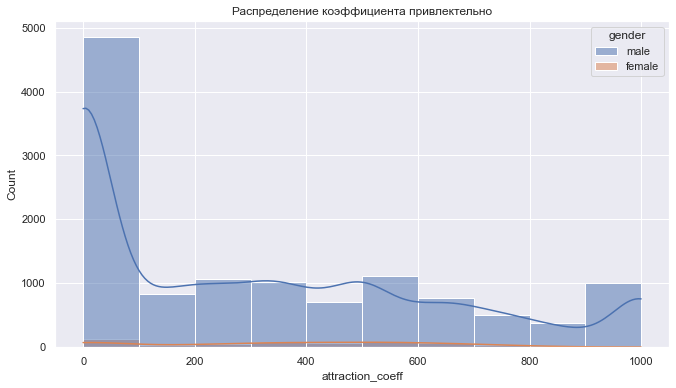

In [266]:
sns.histplot(data=users, x="attraction_coeff", kde=True, hue='gender', bins=10)\
    .set_title("Распределение коэффициента привлектельно")
sns.set(rc={'figure.figsize': (11, 6)})
plt.show()

 Распредлеление attraction_coeff не является нормальным, поэтому для оценки наличия разницы между значениями конверсии просмотра в лайк для мужчин и женщин воспользуемся непараметрическим статистическим тестом -  U-критерий Манна — Уитни

In [267]:
U1, p = mannwhitneyu(users.query('gender == "male"').attraction_coeff,
    users.query('gender == "female"').attraction_coeff)
print(f'U1 = {U1}, p = {round(p, 5)}')

U1 = 2963232.0, p = 0.0


p < 0.05, следовательно различия между мужчинами и женщинами явлются статистически значимыми. Тем самым мы определили то, что мужчины чаще женщин ставят лайки при просмотре профилей женщин

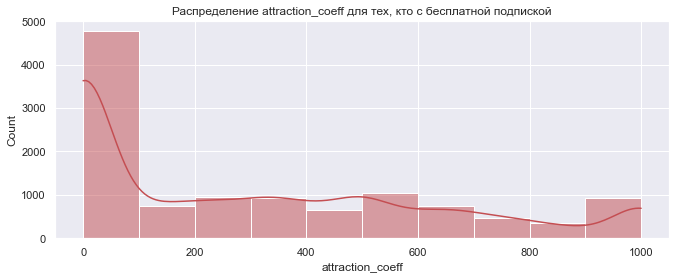

In [269]:
sns.histplot(data=users.query('user_type == "free"'), x="attraction_coeff",
    kde=True, bins=10, color='r')\
    .set_title("Распределение attraction_coeff для тех, кто с бесплатной подпиской")
sns.set(rc={'figure.figsize':(11,4)})
plt.show()

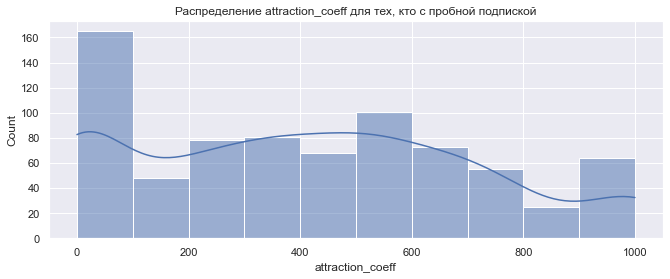

In [270]:
sns.histplot(data=users.query('user_type == "probe"'), x="attraction_coeff", kde=True, bins=10)\
    .set_title("Распределение attraction_coeff для тех, кто с пробной подпиской")
sns.set(rc={'figure.figsize': (11, 4)})
plt.show()

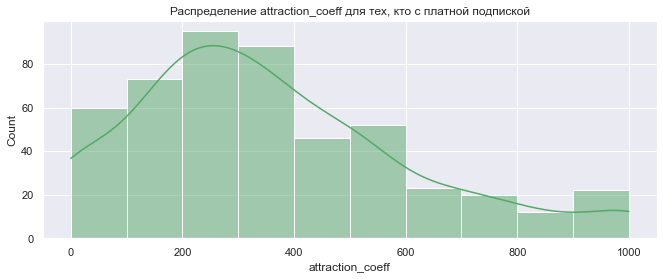

In [271]:
sns.histplot(data=users.query('user_type == "payer"'), x="attraction_coeff", kde=True, bins=10, color='g')\
    .set_title("Распределение attraction_coeff для тех, кто c платной подпиской")
sns.set(rc={'figure.figsize': (11, 4)})
plt.show()

Можно сделать вывод о том, премиум версия действительно работает, ведь она заметно увеличивает конверсию просмотра в лайк. Особенно это заметно на пробном периоде. Возможно, те, кто покупает платную версию имеют ниже величину конверсии только по той самой причине, что вынуждены купить полную версию так как внешне анкета не очень, и за время пробной версии пользователь не нашел свою пару.

Анализ дней на платформе:

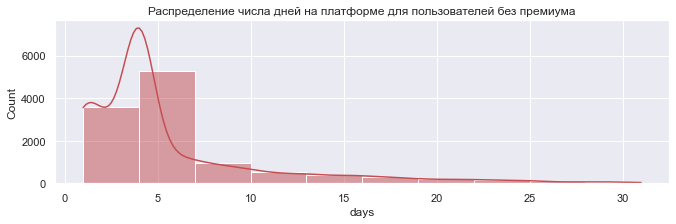

In [273]:
sns.histplot(data=users.query('user_type == "free"'), x="days", kde=True, bins=10, color ='r')\
    .set_title("Распределение числа дней на платформе для пользователей без премиума")
sns.set(rc={'figure.figsize': (11, 3)})
plt.show()

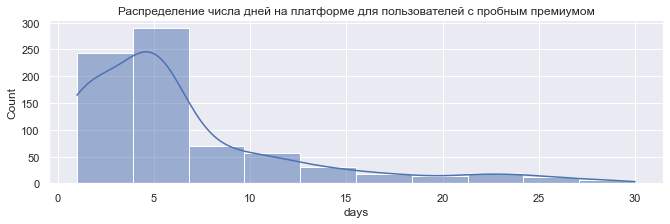

In [274]:
sns.histplot(data=users.query('user_type == "probe"'), x="days", kde=True, bins=10)\
    .set_title("Распределение числа дней на платформе для пользователей с пробным премиумом")
sns.set(rc={'figure.figsize': (11, 3)})
plt.show()

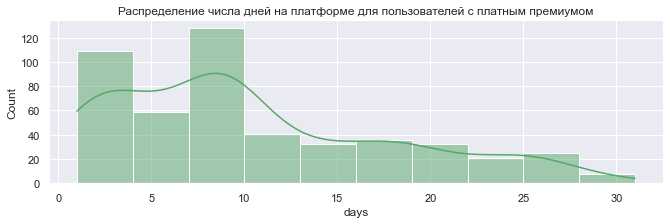

In [275]:
sns.histplot(data=users.query('user_type == "payer"'), x="days", kde=True, bins=10,color='g')\
    .set_title("Распределение числа дней на платформе для пользователей с платным премиумом")
sns.set(rc={'figure.figsize': (11, 3)})
plt.show()

Заметно, что при подключении премиума среднее число дней на платформе увеличилось. А при оплате премиума видно значительное увеличение числа дней. Таким образом, оплата дополнительно мотивирует посещать платформу на более регулярной основе

### Оценка системы сплитования данных users на группы

Оценим качество системы сплитования. В идеале для более объективной оценки набор групп должен быть максимально схож по распределениям таких параметров, как возраст конкурсантов, гендер, страна проживания. В таком случае после А/В будет более точно отражать реальное состояние дел (То есть выборки А и В должны иметь одинаковое в пропорции число конкурсантов из одной страны, должны иметь равное соотношение мужчин и женщин, а также одинаковое возрастное соотношение) <br />
Так как если мы сделаем изменение цены у большинства пользователей старшего возраста, а контрольную выборку сделаем состоящей лишь из молодежи, то результаты А B теста вряд ли можно будет назвать объективными, ведь платежеспособность у всех разная <br />
Во время обозначения метрик для проведения A/B тестов будет проведено А/A тестирование, которое должно будет подтвердить или опровергнуть правильность работы системы сплитования. То, что я делаю в данном разделе - это пытаюсь предугадать результат A/A теста до его проведения и заранее ищу возможные причины причины сбоев при разделении на группы, которые могут сказаться на объективности исследований


Так как распределения возраста внешне близки к нормальным, поэтому для определения, имеется ли зависимость среднего возраста пользователей от тестовой группы воспользуемся дисперсионным анализом (one-way ANOVA):

In [276]:
F, p = f_oneway(users.query('group =="A1"').age, 
    users.query('group =="A2"').age, 
    users.query('group =="B"').age)

In [277]:
print ('p =', p, '< 0.05 => отличия статистически не значимы')

p = 0.6911208622933104 < 0.05 => отличия статистически не значимы


То есть можно считать, что в каждой группе примерно одинаковый возрастной состав

In [278]:
df = users.groupby(['country', 'group'], as_index=False).agg({'uid': 'count'})

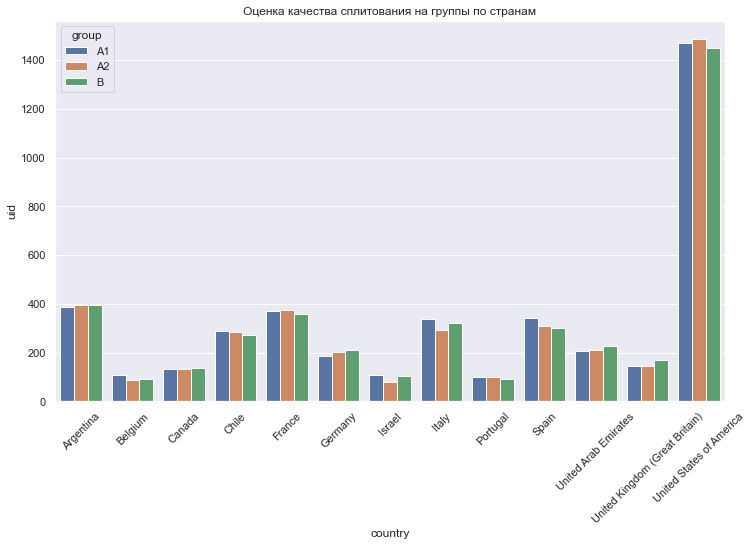

In [280]:
sns.barplot(data=df.query('uid > 70'), x="country", y='uid', hue="group")\
    .set_title("Оценка качества сплитования на группы по странам")
sns.set(rc={'figure.figsize': (12, 7)})
plt.xticks(rotation=45)
plt.show()

Как мы видим, данные распределены практически равномерно по странам.

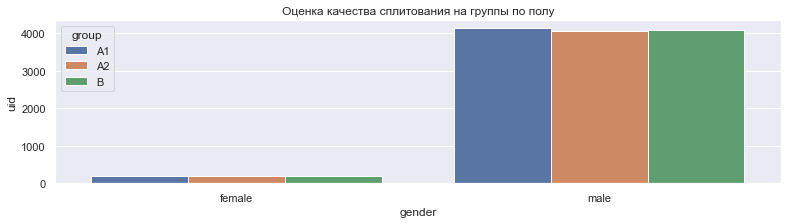

In [282]:
df = users.groupby(['gender', 'group'], as_index=False).agg({'uid': 'count'})
sns.barplot(data=df.query('uid > 70'), x="gender", y='uid', hue="group")\
    .set_title("Оценка качества сплитования на группы по полу")
sns.set(rc={'figure.figsize': (13, 3)})
plt.show()

Как мы видим, данные распределены практически равномерно по полу.

Таким образом, можно сказать, что данные в группах распределены равномерно, что дает возможность считать, что A/A тестирование не обнаружит значимых отклонений между двумя контрольными группами. (будет проведено позже)

### Предобработка данных transactions:

In [283]:
transactions.dtypes

uid             float64
country          object
joined_at        object
paid_at          object
revenue         float64
payment_id      float64
from_page        object
product_type     object
group            object
dtype: object

In [284]:
transactions.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,B
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,B
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,B
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,B
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,B


Поменяем тип данных колонок joined_at и paid_at на to_datetime. Уберем .0 в uid чтоб оформление было схожим с таблицей users

In [285]:
transactions.joined_at = pd.to_datetime(transactions.joined_at)
transactions.paid_at = pd.to_datetime(transactions.paid_at)
transactions = transactions.astype({'uid': 'str'})

In [286]:
transactions.uid = transactions.uid.apply(lambda x: x.split('.')[0])

In [287]:
transactions.uid.value_counts().head(6)

nan          630
892333905     27
892236423     14
892069554     11
891637005     11
892230228     10
Name: uid, dtype: int64

Таким образом, мы видим, что в данной таблице значения uid могут повторяться по несколько раз. Присоединение этого датасета к users не даст никакой новой информации. К тому же, для анализа прибыли нам важнее будет параметр total_revenue, нежели revenue за одну конкретную транзакцию.

Таким образом, будем использовать таблицу transactions для оценки данных о времени. Найдем самого первого пользователя, получим распределение по времени числа транзакций и прочую информацию

In [288]:
transactions.nunique()

uid             527
country          23
joined_at       525
paid_at         893
revenue         265
payment_id        7
from_page        28
product_type      4
group             3
dtype: int64

In [289]:
transactions['joined_at'].sort_values().head(5)

338   2015-01-19 11:49:00
374   2015-01-19 11:49:00
497   2015-01-19 11:49:00
469   2017-01-11 01:06:00
615   2017-01-11 01:06:00
Name: joined_at, dtype: datetime64[ns]

Обратим внимание, что первые 3 человека были в 2015 году. Следующие юзеры зашли лишь 2017. Так что можем предположить, что нашли в датасете трех тестировщиков

In [290]:
transactions[transactions['joined_at'] == "2015-01-19 11:49:00"]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
338,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,A1
374,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,A1
497,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,A1


Интересный факт! Разработчики все из России

In [291]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print(transactions.describe(include='datetime64'))

                  joined_at              paid_at
count                   978                  978
unique                  525                  893
top     2017-10-16 01:38:00  2017-10-16 02:08:00
freq                     27                    5
first   2015-01-19 11:49:00  2016-12-14 16:16:00
last    2017-10-31 23:40:00  2017-12-11 23:28:00


Как я понял, оплата происходит по истечении периода использования и юзер платит сразу за все время пребывания. По этой причине цена так сильно разнится. Найдем время подписки как разность между колонками

In [292]:
transactions['delta'] = transactions['paid_at'] - transactions['joined_at']

In [293]:
transactions['delta'].sort_values(ascending=False).head(5)

374   695 days 05:46:00
338   695 days 05:41:00
497   695 days 04:27:00
523   306 days 16:58:00
266   302 days 00:42:00
Name: delta, dtype: timedelta64[ns]

In [294]:
transactions.query('product_type == "premium_no_trial"').groupby('group')\
    .revenue.value_counts().to_frame().rename(columns={'revenue': 'amount'})\
    .sort_values('amount', ascending=False).head(8)
# Данные по самым распостраненным ценникам на оплаты premium_no_trial подписки по группам

amount
group revenue        
A1    6292.0       43
A2    6292.0       40
B     12597.0      15
A2    4537.0       13
A1    4537.0        8
B     9100.0        6
      6292.0        5
      9217.0        4

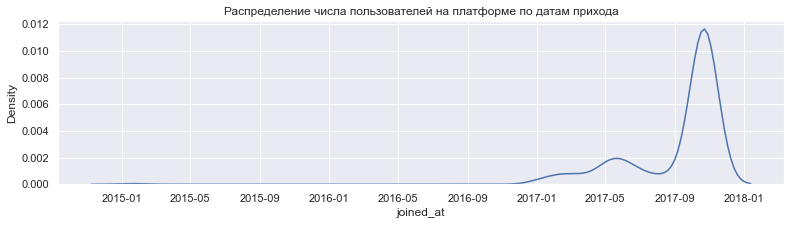

In [295]:
sns.kdeplot(data=transactions, x="joined_at")\
            .set_title("Распределение числа пользователей на платформе по датам прихода");

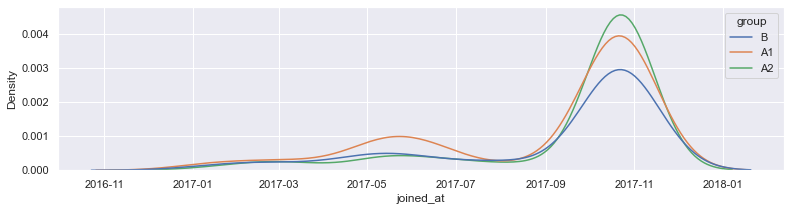

In [296]:
sns.kdeplot(data=transactions.query('joined_at > "2016-12-01"'), x="joined_at",
    color = 'r', hue = 'group');

Видно, что в открытый доступ приложение было добавлено в начале 2017 года. В конце этого же года произошел резкий всплеск оформления транзакций, то есть приложение стало получать максимальную прибль

## Проведение А/А и A/B тестирований

### Определение метрик:

Для оценки влияния изменения цены премиум подписки будем использовать следующие метрики:

1) Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта 

2) Конверсия пользователя из владельца пробной подписки в обладателя платной подписки премиум аккаунта

3) ARPU (Average revenue per user) - для оценки средней выручки одного пользователя 

4) ARPPU (Average revenue per paying user) - для оценки средней выручки одного платящего пользователя 

### А/A тестирования

**I) Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта 
и конверсия пользователя из владельца пробной подписки в обладателя платной подписки премиум аккаунта**

In [297]:
tabAA= pd.crosstab(users[users['group'] != 'B' ].user_type, users[users['group'] != 'B' ].group)
tabAA

group,A1,A2
user_type,,
free,3884,3829
payer,179,173
probe,256,236


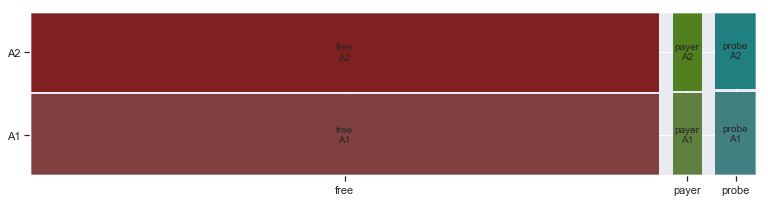

In [298]:
mosaic(tabAA.stack(), gap=0.02);

In [299]:
g, p, dof, expctd = chi2_contingency(tabAA)
print('р уровень значимости равен:', p, ', то есть р > 0.05')

р уровень значимости равен: 0.7630804497706578 , то есть р > 0.05


Таким образом, нельзя отклонить 0 гипотезу об отсутствии влияния контрольных выборок на конверсии. То есть для обоих групп A1 и A2 разница между конверсиями статистически незначимая

In [300]:
a1 = 'Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта для A1 равна:'
a2 = 'Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта для A2 равна:'
print(a1, round(179 * 100 / (3884 + 179 + 256), 3), '%')
print(a2, round(173 * 100 / (3829 + 173 + 236), 3), '%')

Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта для A1 равна: 4.144 %
Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта для A2 равна: 4.082 %


In [301]:
a1 = 'Конверсия пользователя из владельца пробной подписки в обладателя платной подписки премиум аккаунта для A1 равна:'
a2 = 'Конверсия пользователя из владельца пробной подписки в обладателя платной подписки премиум аккаунта для A2 равна:'
print(a1, round(179 * 100 / (256 + 179), 3), '%')
print(a2, round(173 * 100 / (236 + 173), 3), '%')

Конверсия пользователя из владельца пробной подписки в обладателя платной подписки премиум аккаунта для A1 равна: 41.149 %
Конверсия пользователя из владельца пробной подписки в обладателя платной подписки премиум аккаунта для A2 равна: 42.298 %


Посчитанная ранее конверсия имеет следующий смысл - доля пользователей с приобретенной платной подпиской ко всем, кто попробовал премиум подписку

**II) ARPU (Average revenue per user) - для оценки средней выручки одного пользователя**


Проверим данную бизнес-метрику не один раз, а с помощью синтетических симуляций (2000 штук)

  0%|          | 0/2000 [00:00<?, ?it/s]

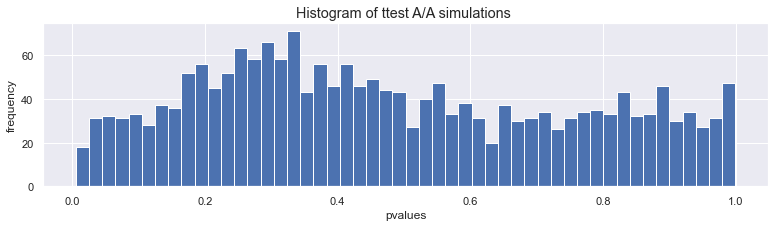

In [302]:
simulations = 2000 # число симуляций
n_s = 800 # число элементов, берущихся из выборки для проведения единичного t теста
res = []

d0 = users.query('group == "A1"').total_revenue
d1 = users.query('group == "A2"').total_revenue

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = d0.sample(n_s, replace=False).values
    s2 = d1.sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2, equal_var=False)[1]) # сохраняем pvalue

plt.hist(res, bins=50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [303]:
# Проверяем, что количество ложноположительных случаев не превышает альфа = 0.05
sum(np.array(res) < 0.05) / simulations

0.0295

Распределение получилось очень близким к равномерному. Это говорит о том, что А/A тестирование не выявило проблем с системой сплитования

In [304]:
print('ARPU A1 =', round(users.query('group == "A1"').total_revenue.mean(), 3))

ARPU A1 = 597.654


In [305]:
print('ARPU A2 =', round(users.query('group == "A2"').total_revenue.mean(), 3))

ARPU A2 = 447.264


**III) ARPPU (Average revenue per paying user) - для оценки средней выручки одного платящих пользователей**

Проверим данную бизнес-метрику не один раз, а с помощью синтетических симуляций (2000 штук)

  0%|          | 0/2000 [00:00<?, ?it/s]

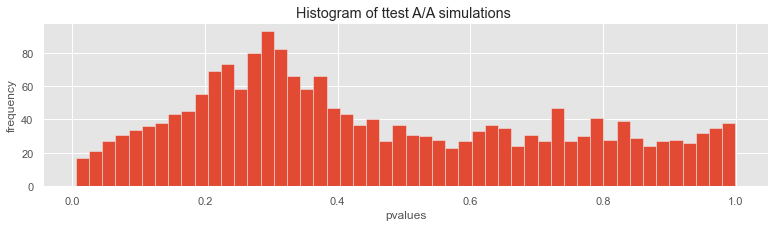

In [306]:
simulations = 2000 # число симуляций
n_s = 50 # число элементов, берущихся из выборки для проведения единичного t теста
res = []
lower_treshhold = 0

d0=users.query('group == "A1" and total_revenue > 0').total_revenue
d1=users.query('group == "A2" and total_revenue > 0').total_revenue

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = d0.sample(n_s, replace=False).values
    s2 = d1.sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2, equal_var=False)[1]) # сохраняем pvalue
    if stats.ttest_ind(s1, s2, equal_var=False)[1] < 0.05:
        lower_treshhold += 1

plt.hist(res, bins=50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [307]:
# Проверяем, что количество ложноположительных случаев не превышает альфа = 0.05
lower_treshhold / simulations  # доля p значений менее 0.05 

0.022

Распределение получилось близким к равномерному. Это говорит о том, что А/A тестирование не выявило проблем с системой сплитования

In [308]:
print('ARPPU A1 =', round(users.query('group == "A1" and total_revenue > 0')\
    .total_revenue.mean(), 3))

ARPPU A1 = 13444.099


In [309]:
print('ARPPU A2 =', round(users.query('group == "A2" and total_revenue > 0').total_revenue.mean(), 3))

ARPPU A2 = 10245.968


Таким образом, система сплитования работает исправно. Мы и до этого во время проверки равномерности пользователей (отсутствия дисбаланса) предсказывали такой результат, а сейчас в этом окончательно убедились. <br />
Теперь можно приступать к A/B тестированию 

### A/B тестирование

Объединим A1 и A2 в общую группу А:

In [310]:
users['group'] = users['group'].apply(lambda x: 'A' if x != 'B' else 'B')

In [311]:
users.group.value_counts()

A    8557
B    4271
Name: group, dtype: int64

**I) Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта 
и конверсия пользователя из владельца пробной подписки в обладателя платной подписки премиум аккаунта**

H0 - изменение цены подписки в двух новых платежных системах не влияет на факт покупки премиум-аккаунта <br />
H1 - влияние имеется

In [312]:
tabAB= pd.crosstab(users.user_type, users.group)
tabAB

group,A,B
user_type,,
free,7713,3866
payer,352,139
probe,492,266


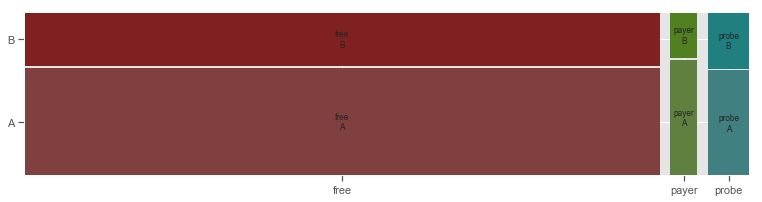

In [313]:
mosaic(tabAB.stack(), gap=0.015);

In [314]:
g, p, dof, expctd = chi2_contingency(tabAB)
print('р уровень значимости равен:', p, ', то есть р < 0.05')

р уровень значимости равен: 0.036107839852166486 , то есть р < 0.05


Таким образом, мы отвергаем 0 гипотезу об отсутствии влияния контрольных выборок на конверсии. В данный момент мы поняли то, что влияние имеется, но на какую из конверсий нам еще предстоит определить с помощью критерия  χ2:

**1) Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта:**

Надо учитывать, что обладатели пробного аккаунта тоже по сути бесплатные юзеры. Так что учтем этот факт:

In [315]:
users['user_type_AB'] = users['user_type']\
    .apply(lambda x: 'free+probe' if x != 'payer' else 'payer')

In [316]:
users['user_type_AB'].value_counts()

free+probe    12337
payer           491
Name: user_type_AB, dtype: int64

In [317]:
tabAB1= pd.crosstab(users.user_type_AB, users.group)
tabAB1

group,A,B
user_type_AB,,
free+probe,8205,4132
payer,352,139


In [318]:
g, p, dof, expctd = chi2_contingency(tabAB1)
print('р уровень значимости равен:', p, ', то есть р < 0.05 => отвергаем 0 гипотезу')

р уровень значимости равен: 0.01922390112695724 , то есть р < 0.05 => отвергаем 0 гипотезу


In [319]:
a1 = 'Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта для контрольной группы равна:'
a2 = 'Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта для тестовой группы равна:'
print(a1, round(352 * 100 / (8205 + 352), 3), '%')
print(a2, round(139 * 100 / (4132 + 139), 3), '%')

Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта для контрольной группы равна: 4.114 %
Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта для тестовой группы равна: 3.255 %


Таким образом, мы определили, что при изменении цены подписки на премиум аккаунт конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта именилась статистически существенно. (а именно - уменьшилась)

**2) Конверсия пользователя из владельца пробной подписки в обладателя платной подписки премиум аккаунта:**

In [320]:
tabAB2= pd.crosstab(users.query('user_type != "free"').user_type, users.query('user_type != "free"').group)
tabAB2

group,A,B
user_type,,
payer,352,139
probe,492,266


In [321]:
g, p, dof, expctd = chi2_contingency(tabAB2)
print('р уровень значимости равен:', p, ', то есть р < 0.05 => отвергаем 0 гипотезу')

р уровень значимости равен: 0.014710908936680377 , то есть р < 0.05 => отвергаем 0 гипотезу


In [322]:
a1 = 'Конверсия пользователя из владельца пробной подписки в обладателя платной подписки премиум аккаунта для контр. группы равна:'
a2 = 'Конверсия пользователя из владельца пробной подписки в обладателя платной подписки премиум аккаунта для тестовой группы равна:'
print(a1, '\n', round(352 * 100 / (352 + 492), 3), '%')
print(a2, '\n', round(139 * 100 / (139 + 266), 3), '%')

Конверсия пользователя из владельца пробной подписки в обладателя платной подписки премиум аккаунта для контр. группы равна: 
 41.706 %
Конверсия пользователя из владельца пробной подписки в обладателя платной подписки премиум аккаунта для тестовой группы равна: 
 34.321 %


Таким образом, мы определили, что при изменении цены подписки на премиум аккаунт конверсия пользователя из владельца пробной подписки в обладателя платной подписки премиум аккаунта изменилась статистически существенно. (а именно - уменьшилась)

До этого на не было сказано, в какую сторону произошли изменения цены. Исходя из полученных данных о статистически значимых уменьшениях конверсии, можно сделать вывод о том, что цена премиум подписок для тестовой группы была увеличена.

**II) ARPU (Average revenue per user) - средняя нормированная выручка на одного пользователя:**

Распределение total_revenue не является нормальным, поэтому для определения наличия статистически значимых различий между выручкой в тестовой и контрольной выборках можно использовать непараметрический U-критерий Манна — Уитни. Но для бизнесовых задач данный критерий не является востребованным. Предпочтительнее в данном случае использовать bootstrap для проверки статистических гипотез.

Гипотезы:<br /> 
H0 - изменение цены подписки в двух новых платежных системах не влияет на среднюю выручку на одного пользователя <br />
H1 - влияние имеется.

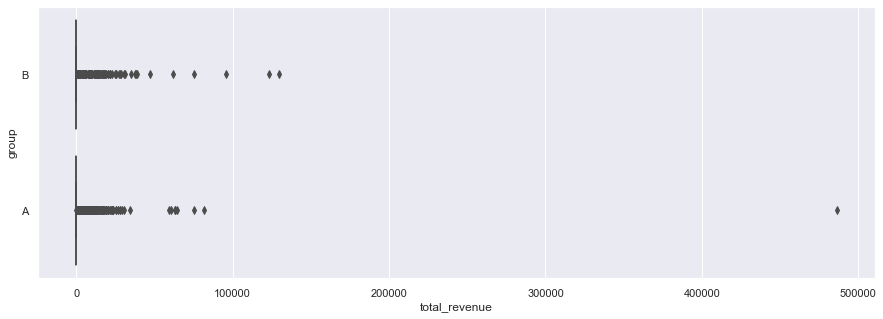

In [324]:
sns.set(rc={'figure.figsize': (15, 5)})
sns.boxplot(data=users, x="total_revenue", y="group");

In [325]:
users.groupby('group').agg({'total_revenue': 'median'})\
    .rename(columns={'total_revenue': 'median'})

,median
group,
A,0.0
B,0.0


В случае больших выбросов целесообразным при оценивании методом bootstap использовать анализ медиан, но по причине того, что большинство пользователей используют именно бесплатную версию, медианное значение будет равняться 0 и станет неинформативным. Судя по boxplot, целесообразным будет в данных контрольной и тестовой выборок убрать очень выделяющийся из остальных значений выброс и далее с полученными данными провести bootstrap анализ средних значений выручки (total_revenue < 100000 - критерий для отсекания выбросов)

In [326]:
users.query('total_revenue < 100000').groupby('group')\
    .agg({'total_revenue': 'mean'}).rename(columns={'total_revenue': 'ARPU'})

,ARPU
group,
A,466.390954
B,477.226985


Объявим функцию, которая позволит проверять гипотезы с помощью бутстрэпа

In [327]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

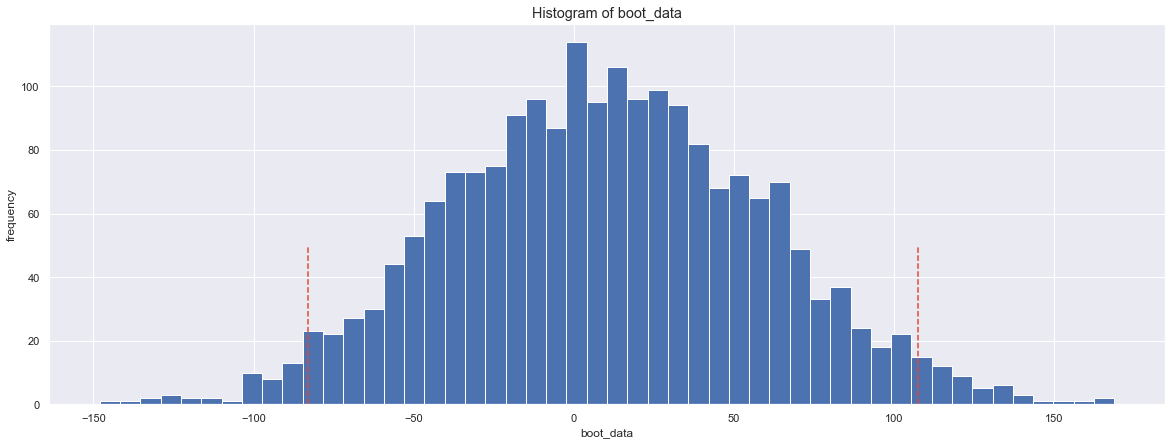

In [328]:
sns.set(rc={'figure.figsize': (20, 7)})
x = users.query('total_revenue < 100000 and group == "A"').total_revenue
y = users.query('total_revenue < 100000 and group == "B"').total_revenue
booted_data = get_bootstrap(y, x, boot_it=2000)

In [329]:
booted_data["ci"] # местоположение хвостов границ

,0
0.025,-83.077764
0.975,107.536179


In [330]:
print('p =', round(booted_data["p_value"], 3), '> 0.05' )

p = 0.834 > 0.05


In [331]:
a = 1 - booted_data["p_value"] # доля значений за пределами границ 
print(a)

0.1660636742885695


Мы получили результат, говорящий о том, что данные тестовой и контрольной выборок существенно не различаются. С вероятностью менее 0.16 значение разности средних значений данных по выручке не содержит 0 в своем доверительном интервале. То есть средние значения распределений не различаются значимо. Принимаем 0 гипотезу

**III) ARPPU (Average revenue per paying user), средняя выручка на одного платящего пользователя**

Гипотезы:<br /> 
H0 - изменение цены подписки в двух новых платежных системах не влияет на среднюю выручку на одного платящего пользователя <br />
H1 - влияние имеется.

In [332]:
users.query('total_revenue > 0').groupby('group')\
    .agg({'total_revenue': 'median'})\
    .rename(columns={'total_revenue': 'median'})

,median
group,
A,9087.0
B,12727.0


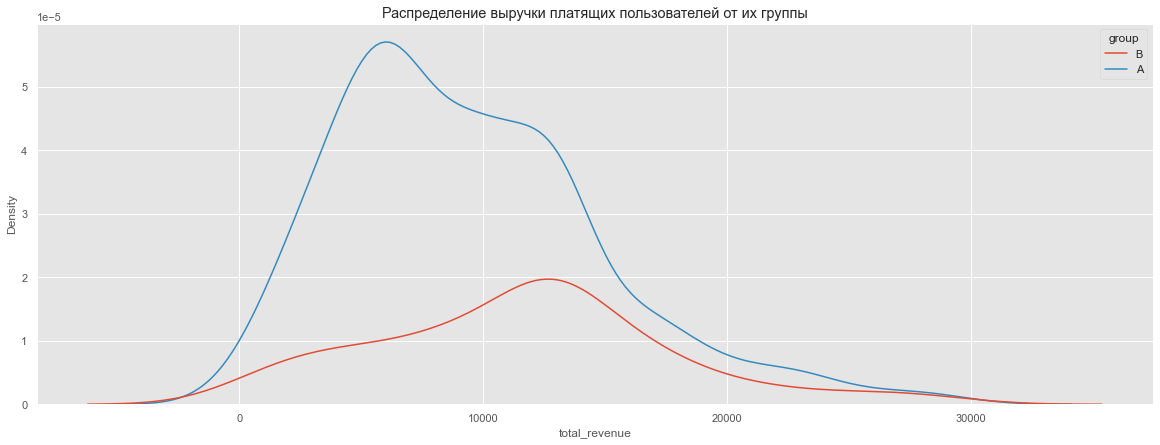

In [333]:
sns.kdeplot(data=users.query('total_revenue < 30000 and total_revenue > 0'), x="total_revenue", hue='group')\
    .set_title("Распределение выручки платящих пользователей от их группы")
sns.set(rc={'figure.figsize': (11, 6)})
plt.show()

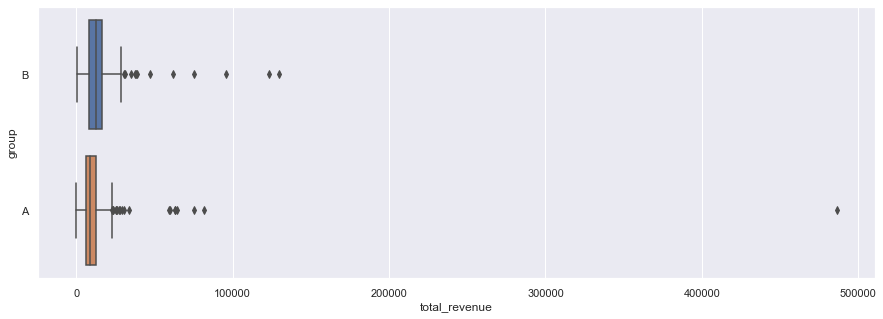

In [334]:
sns.set(rc={'figure.figsize': (15, 5)})
sns.boxplot(data=users.query('total_revenue > 0'), x="total_revenue", y="group");

Исходя из проведенного анализа было определено, что в тестовой и контрольной выборках имеются ярко выраженные выбросы, делающие значение среднего неинформативным для анализа. Поэтому было принято решение оценивать распределения с помощью bootstrap по параметру медианы. 
То есть анализ медиан будет более информативным. 

  0%|          | 0/2000 [00:00<?, ?it/s]

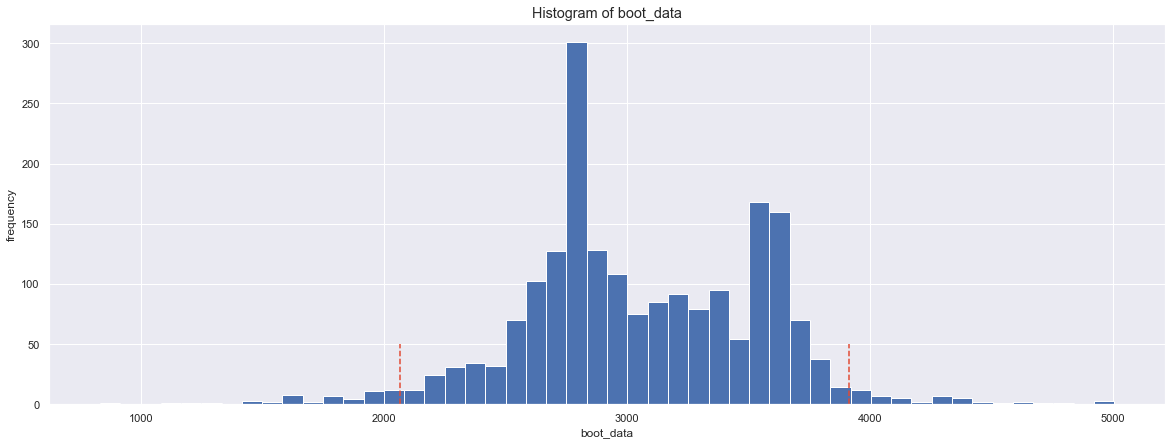

In [335]:
sns.set(rc={'figure.figsize': (20, 7)})
x = users.query('total_revenue > 0 and group == "A"').total_revenue
y = users.query('total_revenue > 0 and group == "B"').total_revenue
booted_data = get_bootstrap(y, x, boot_it=2000, statistic=np.median)

In [336]:
booted_data["ci"] # местоположение хвостов границ

,0
0.025,2066.35
0.975,3913.00


In [337]:
print('p =', round(booted_data["p_value"], 3), '< 0.05' )

p = 0.0 < 0.05


In [338]:
a = 1 - booted_data["p_value"] # доля значений за пределами границ 
print(a)

0.999999999391138


Мы получили результат, говорящий о том, что данные тестовой и контрольной выборок существенно различаются. С вероятностью более 0.999 значение разности медиан данных по выручке платящих пользователей превосходит 0. То есть медианы распределений значимо различны. Отклоняем 0 гипотезу.

In [339]:
users.query('total_revenue > 0').groupby('group')\
    .agg({'total_revenue': 'mean'})\
    .rename(columns={'total_revenue': 'ARPPU'})\
    .apply(lambda x: x.round(2))

,ARPPU
group,
A,11874.72
B,15798.05


В результате проведения A/B тестирования стало ясно следующее:

1) После увеличения цены на подписку доля людей, приобретающих платную премиум подписку и доля людей, продляющих пробную подписку, статистически значимо снизилась. <br />
2) Средняя выручка с пользователей платформы онлайн-знакомств при этом статистически значимо не изменилась. <br />
3) Медианная выручка с платящих пользователей при этом статистически значимо возросла.<br />

Стоит отметить то, что для любого бизнеса самым значимым критерием всегда является доход и вовлеченность пользователей, поэтому, в связи с отсутствием изменения доходности и лишь падением конверсии пользователей в платных подписчиков, можно сделать вывод о нецелесообразности проведения изменений цены подписки для для всех категорий пользователей (значение медианной выручки платящих хоть и увеличилась но это связано лишь с тем, что сама цена подписки возрасла и учитывались лишь категоря и так платящих пользователей)

### Проведем поиск категории пользователей, для которых релевантными будут изменения цены:

Как уже было сказано ранее, будем искать по метрике средей выручки на пользователя ARPU. Цель - найти условие, чтоб p стало менее 0.05

Условие: только для мужчин

  0%|          | 0/2000 [00:00<?, ?it/s]

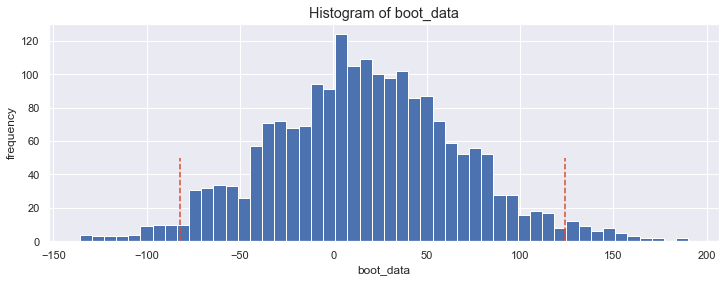

p уровень значимости равен: 0.739


In [340]:
sns.set(rc={'figure.figsize': (12, 4)})
x = users.query('total_revenue < 100000 and group == "A" and gender == "male"').total_revenue
y = users.query('total_revenue < 100000 and group == "B" and gender == "male"').total_revenue
booted_data = get_bootstrap(y, x, boot_it=2000)
print('p уровень значимости равен:', round(booted_data["p_value"], 3))

Условие: только для женщин

  0%|          | 0/2000 [00:00<?, ?it/s]

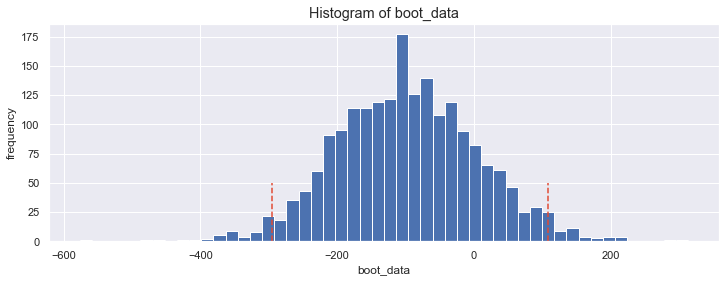

p уровень значимости равен: 0.343


In [341]:
sns.set(rc={'figure.figsize':(12, 4)})
x = users.query('total_revenue < 100000 and group == "A" and gender == "female"').total_revenue
y = users.query('total_revenue < 100000 and group == "B" and gender == "female"').total_revenue
booted_data = get_bootstrap(y, x, boot_it=2000)
print('p уровень значимости равен:', round(booted_data["p_value"], 3))

Условие: молодежь до 30 лет

  0%|          | 0/2000 [00:00<?, ?it/s]

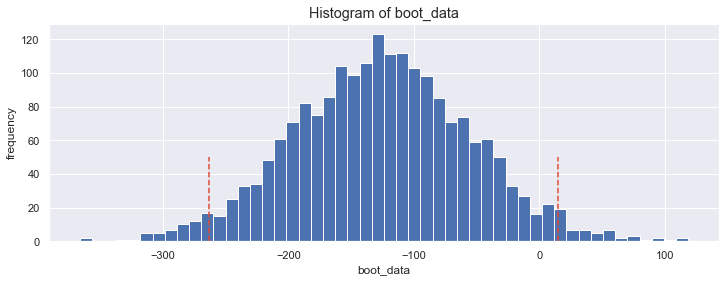

p уровень значимости равен: 0.076


In [342]:
sns.set(rc={'figure.figsize': (12, 4)})
x = users.query('total_revenue < 100000 and group == "A" and age <= 30').total_revenue
y = users.query('total_revenue < 100000 and group == "B" and age <= 30').total_revenue
booted_data = get_bootstrap(y, x, boot_it=2000)
print('p уровень значимости равен:', round(booted_data["p_value"], 3))

Условие: аудитория за 30

  0%|          | 0/2000 [00:00<?, ?it/s]

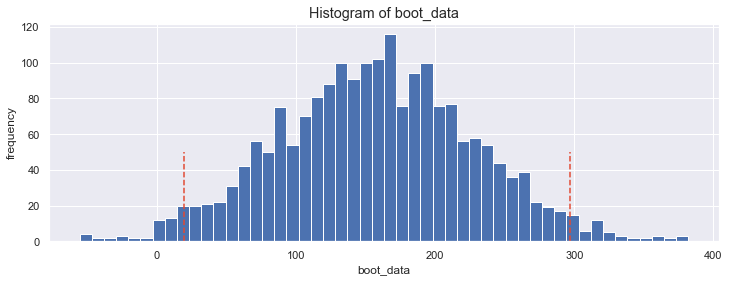

p уровень значимости равен: 0.025


In [343]:
sns.set(rc={'figure.figsize': (12, 4)})
x = users.query('total_revenue < 100000 and group == "A" and age > 30').total_revenue
y = users.query('total_revenue < 100000 and group == "B" and age > 30').total_revenue
booted_data = get_bootstrap(y, x, boot_it=2000)
print('p уровень значимости равен:', round(booted_data["p_value"], 3))

Ура! Мы нашли условие, чтобы p стало менее порога в 0.05. Определим размер аудитории, найдем значения ARPU.

In [344]:
users.query('total_revenue < 100000  and age > 30')\
    .groupby('group').agg({'uid': 'count'})\
    .rename(columns={'uid': 'amount of users'})

,amount of users
group,
A,4126
B,2016


In [345]:
users.query('total_revenue < 100000  and age > 30').groupby('group')\
    .agg({'total_revenue': 'mean'})\
    .rename(columns={'total_revenue': 'ARPU'})\
    .apply(lambda x: x.round(2))

,ARPU
group,
A,422.00
B,580.23


Осталось проверить еще один значимый параметр - конверсию из бесплатных юзеров в обладателей платной премиум подпиской

In [346]:
tabAB = pd.crosstab(users.query('total_revenue < 100000  and age > 30').user_type_AB, 
                   users.query('total_revenue < 100000  and age > 30').group)
tabAB

group,A,B
user_type_AB,,
free+probe,3976,1935
payer,150,81


In [347]:
g, p, dof, expctd = chi2_contingency(tabAB1)
print('р уровень значимости равен:', p, ', то есть р < 0.05 => отвергаем 0 гипотезу')

р уровень значимости равен: 0.01922390112695724 , то есть р < 0.05 => отвергаем 0 гипотезу


In [348]:
a1 = 'Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта для контрольной группы равна:'
a2 = 'Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта для тестовой группы равна:'
print(a1, round(150 * 100 / (3976 + 150), 3), '%')
print(a2, round(81 * 100 / (1935 + 81), 3), '%')

Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта для контрольной группы равна: 3.635 %
Конверсия пользователя с бесплатной подпиской в обладателя платного премиум-аккаунта для тестовой группы равна: 4.018 %


Задание целиком выполнено. <br />
Категория пользователей с целессорбазным выкатыванием изменения цены на премиум подписку найдена.

## Финальные выводы

После предобработки данных было проведено А/A тестирование, которое подтвердило правильность работы системы сплитования данных. Таким образом, данные после предобработки стали пригодными для проведения A/B тестирования. <br /> <br />
В результате проведения A/B тестирования стало ясно следующее:

1) После увеличения цены на подписку доля людей, приобретающих платную премиум подписку и доля людей, продляющих пробную подписку, статистически значимо снизилась. <br />
2) Средняя выручка с пользователей платформы онлайн-знакомств при этом статистически значимо не изменилась. <br />
3) Медианная выручка с платящих пользователей при этом статистически значимо возросла.<br />
<br />
Стоит отметить то, что для любого бизнеса самым значимым критерием всегда является доход и вовлеченность пользователей, поэтому, в связи с отсутствием изменения доходности и лишь падением конверсии пользователей в платных подписчиков, можно сделать вывод о нецелесообразности проведения изменений цены подписки для для всех категорий пользователей (значение медианной выручки платящих хоть и увеличилась но это связано лишь с тем, что сама цена подписки возросла и учитывались лишь категория и так платящих пользователей)
<br /><br />
В связи с этим, была поставлена задача - найти такую категорию пользователей, для которых такое нововведение скажется положительно, то есть для тех, чья средняя выручка лишь возрастет и конверсия в обладателей платной премиум подпиской не снизится. Такой категорией оказалась аудитория за 30 (30+ лет). Данная часть аудитории действительно довольно большая по размеру и для нее такое нововведение лишь увеличило конверсию и при этом увеличило ARPU более чем в 1,3 раза. Такое удивительное являение может быть объяснено тем, что люди более взрослые готовы платить больше сумму денег за платную подписку (финансы позволяют) и к тому же испытывают явно больше трудностей при офлайн знакомствах, из-за чего дают предпочтение онлайн форме.